# Load Checkpoint

In [43]:
from lib.utils import load_config
from lib.models.siamese import Siamese
from pathlib import Path
from lib.data.siamese_datamodule import SiameseDataModule
import hydra
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lib.data.preprocess_sketch import image_grid
import torch
import faiss

ckpt_path = (
    "/home/borth/sketch2shape/logs/train/runs/2023-11-21_20-22-21/checkpoints/last.ckpt"
)
custom_sketch_path = {
    "sketch00": "/home/borth/sketch2shape/data/custom_sketches/d76ec8373d0a8f0dbb44d2e3e3af4857/sketch00.jpg",
    "sketch01": "/home/borth/sketch2shape/data/custom_sketches/d76ec8373d0a8f0dbb44d2e3e3af4857/sketch01.jpg",
    "sketch02": "/home/borth/sketch2shape/data/custom_sketches/d76ec8373d0a8f0dbb44d2e3e3af4857/sketch02.jpg",
    "sketch03": "/home/borth/sketch2shape/data/custom_sketches/9d20e4d4637e66175836897f0d296c15/sketch00.jpg",
    "sketch04": "/home/borth/sketch2shape/data/custom_sketches/9d20e4d4637e66175836897f0d296c15/sketch01.jpg",
    "sketch05": "/home/borth/sketch2shape/data/custom_sketches/9d20e4d4637e66175836897f0d296c15/sketch02.jpg",
}

# load things
cfg = load_config("train_siamese")
model = Siamese.load_from_checkpoint(ckpt_path)
datamodule = hydra.utils.instantiate(cfg.data)
datamodule.setup("fit")
dataset = datamodule.val_dataset

/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.
/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'miner' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['miner'])`.
/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


# Utils

In [2]:
import torchvision
from lib.data.preprocess_sketch import image_to_sketch
import matplotlib.pyplot as plt
import torchvision
from pytorch_metric_learning.distances import LpDistance
def sketch_to_sketch(data):
    img = (transform_to_plot(data.cpu().numpy()) * 255).astype(np.uint8)
    img = image_to_sketch([img])[0]
    return dataset.transforms(img)
def embedd_custom_sketch(data):
    with torch.no_grad():
        out = model.decoder(data.to("cuda")[None])
    return out.flatten().detach().cpu().numpy()

def search(emb, k:int=3):
    search_idx = index.search(np.expand_dims(emb, axis=0), k=k)[1][0]
    return search_idx, image[search_idx]

def get_distance(x, y):
    dist = LpDistance()(torch.tensor(np.expand_dims(x, axis=0)), torch.tensor(np.expand_dims(y, axis=0)))
    return dist.cpu().numpy()

def label_idx(dataset_idx: int, image_idx: int):
    return np.where(dataset_idx== labels)[0].min() + image_idx

def plot_single_image(data):
    data = transform_to_plot(data)
    plt.figure(figsize=(2,2))
    plt.imshow(data)
    plt.axis('off')
    plt.show()

def load_raw_sketch(path):
    data = cv2.imread(path)
    _transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(256),
    ])
    return _transform(dataset.transforms(data))

def transform_to_plot(data, batch=False):
    if batch:
        data = np.transpose(data, (0, 2, 3, 1))
    else:
        data = np.transpose(data, (1, 2, 0))
    data = (((data * 0.5) + 0.5))
    return np.clip(data, 0, 1)

def get_rendered_images(dataset):
    def _generator():
        for obj_id, obj in dataset.data.items():
            yield from dataset.data[obj_id]['images'].values()
    return torch.stack(list(_generator()), dim=0)

def get_sketches(dataset):
    def _generator():
        for idx in range(len(dataset)):
            yield from dataset[idx]['sketches']
    return torch.stack(list(_generator()), dim=0)

def show_sketches(idx):
    image_data = transform_to_plot(dataset[idx]['sketch'], batch=True)
    image_grid(image_data, 4, 8)

def show_rendered_images(idx):
    image_data = transform_to_plot(dataset[idx]['image'], batch=True)
    image_grid(image_data, 4, 8)

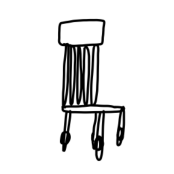

In [3]:
sketch01_raw = load_raw_sketch(custom_sketch_path["sketch04"])
sketch01_emb = embedd_custom_sketch(sketch01_raw)
plot_single_image(sketch01_raw)

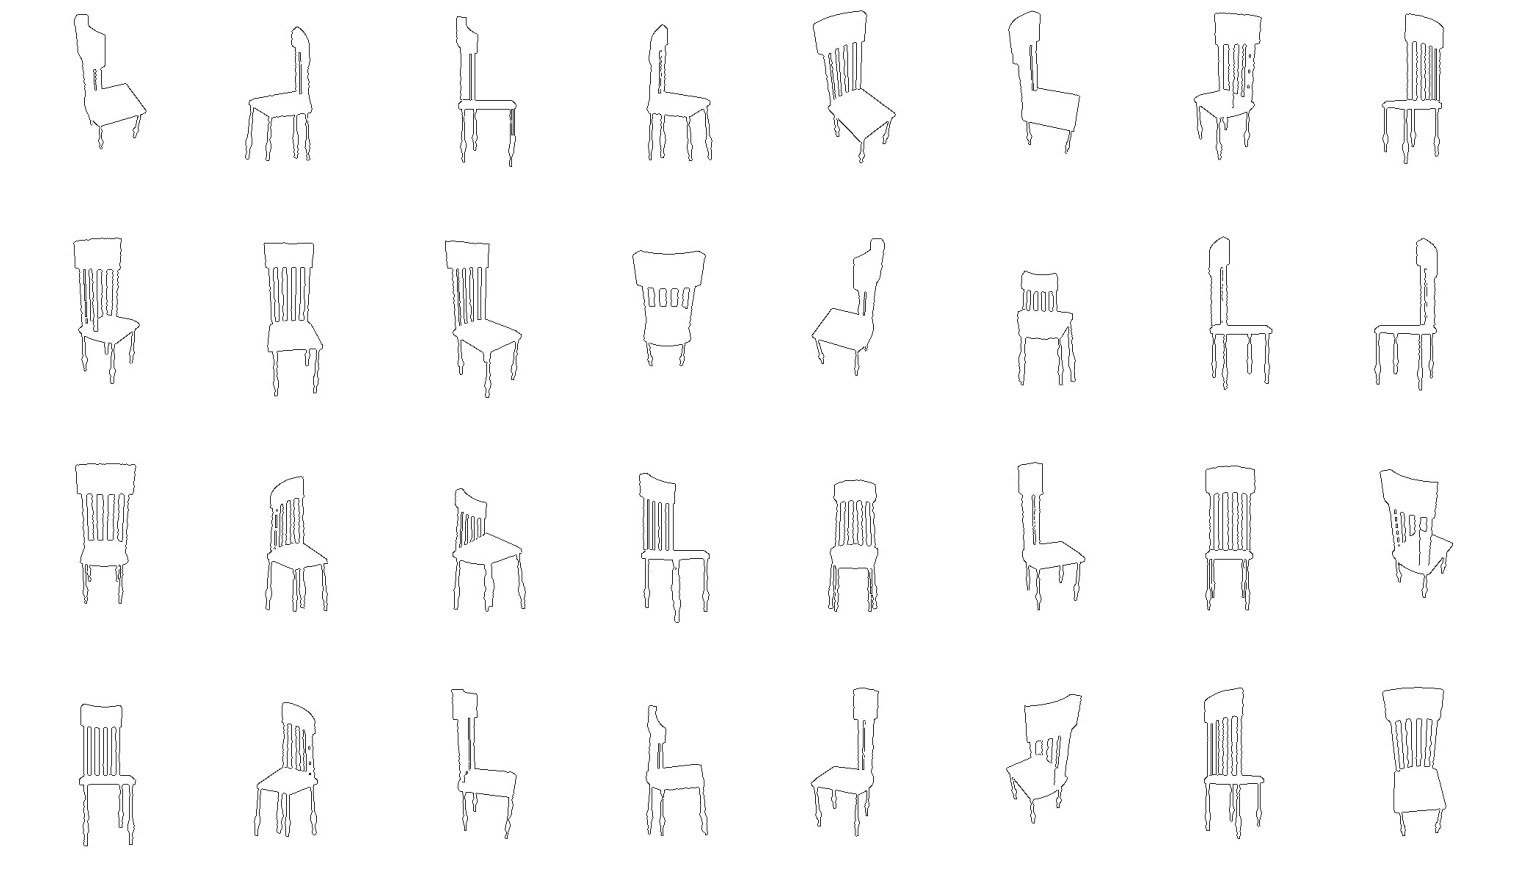

In [4]:
show_sketches(0)

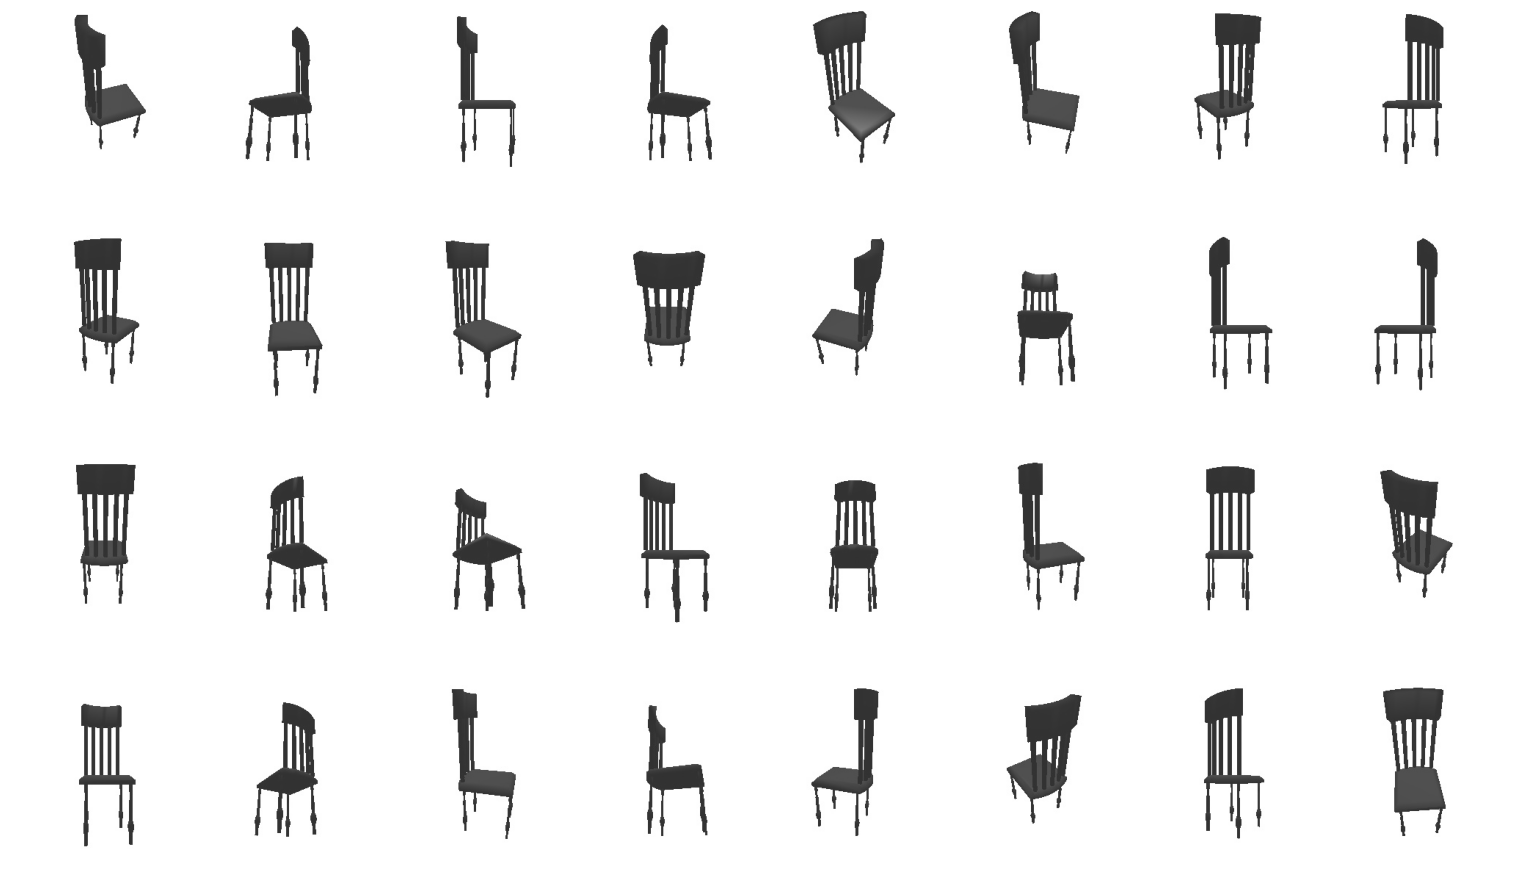

In [5]:
show_rendered_images(0)

In [6]:
from tqdm import tqdm

labels = []
sketch = []
sketch_emb = []
image = []
image_emb = []
model.eval()
for batch in tqdm(datamodule.val_dataloader()):
    sketch.append(batch["sketch"].cpu().numpy())
    image.append(batch["image"].cpu().numpy())
    batch["sketch"] = batch["sketch"].to("cuda")
    batch["image"] = batch["image"].to("cuda")
    labels.append(batch["label"].cpu().numpy())
    with torch.no_grad():
        out = model(batch)
        sketch_emb.append(out["sketch_emb"].detach().cpu().numpy())
        image_emb.append(out["image_emb"].detach().cpu().numpy())
labels = np.concatenate(labels, axis=0)
sketch_emb = np.concatenate(sketch_emb, axis=0)
image_emb = np.concatenate(image_emb, axis=0)
sketch = np.concatenate(sketch, axis=0)
image = np.concatenate(image, axis=0)
index = faiss.IndexFlatL2(32)  
index.add(image_emb)

100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Rendered Image for obj-id=0 and 10 position.


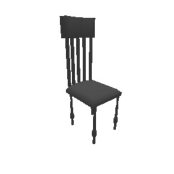

Sketch for obj-id=0 and 10 position.


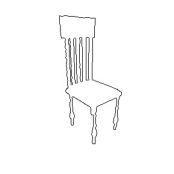

Plot 16-nn retrieval for obj-id=0 and 10 position.
True obj-id: 0
Retrieved object-ids: [106 106   0   0   0 106   0   0   0   0  23   0   0   0   0   0]


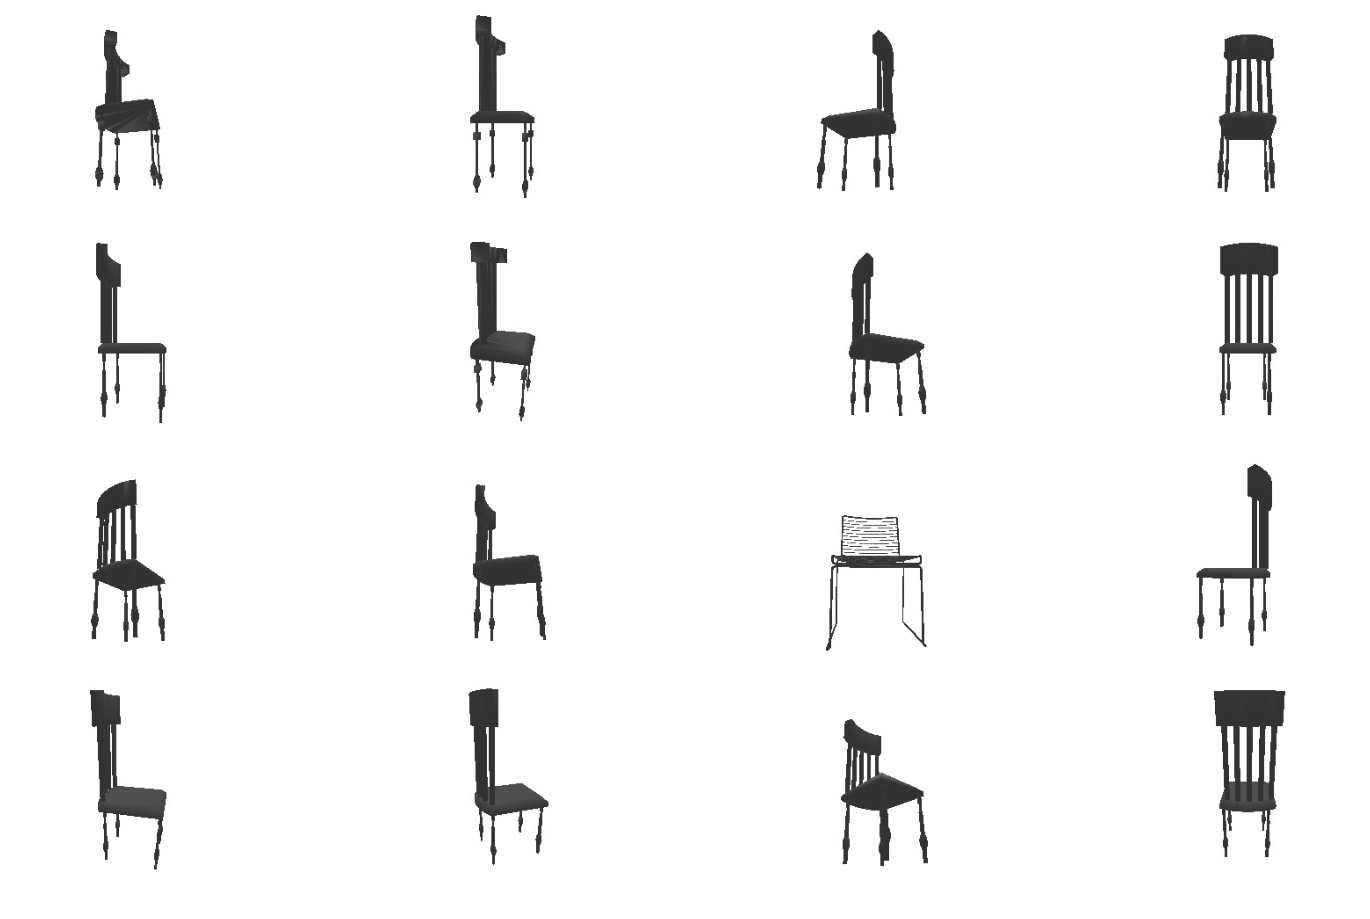

In [7]:
k = 16
true_label = 0 
true_pos = 10

idx = label_idx(true_label, true_pos)
obj_id = labels[idx]
print(f"Rendered Image for obj-id={true_label} and {true_pos} position.")
plot_single_image(image[idx])
print(f"Sketch for obj-id={true_label} and {true_pos} position.")
plot_single_image(sketch[idx])
print(f"Plot {k}-nn retrieval for obj-id={true_label} and {true_pos} position.")
search_idx, knn_images = search(sketch_emb[idx], k=k)
_knn_images = transform_to_plot(knn_images, batch=True)
image_grid(_knn_images, 4, 4)
print(f"True obj-id: {obj_id}")
print(f"Retrieved object-ids: {labels[search_idx]}")

Rendered Image for obj-id=0 and 10 position.


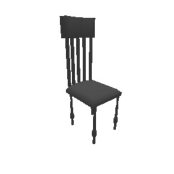

Sketch for obj-id=0 and 10 position.


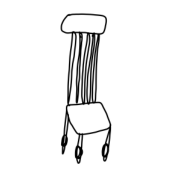

Plot 16-nn retrieval for obj-id=0 and 10 position.
True obj-id: 0
Retrieved object-ids: [106   0   0 106 106   0   0  98   0   0   0 106   0   0   0   0]


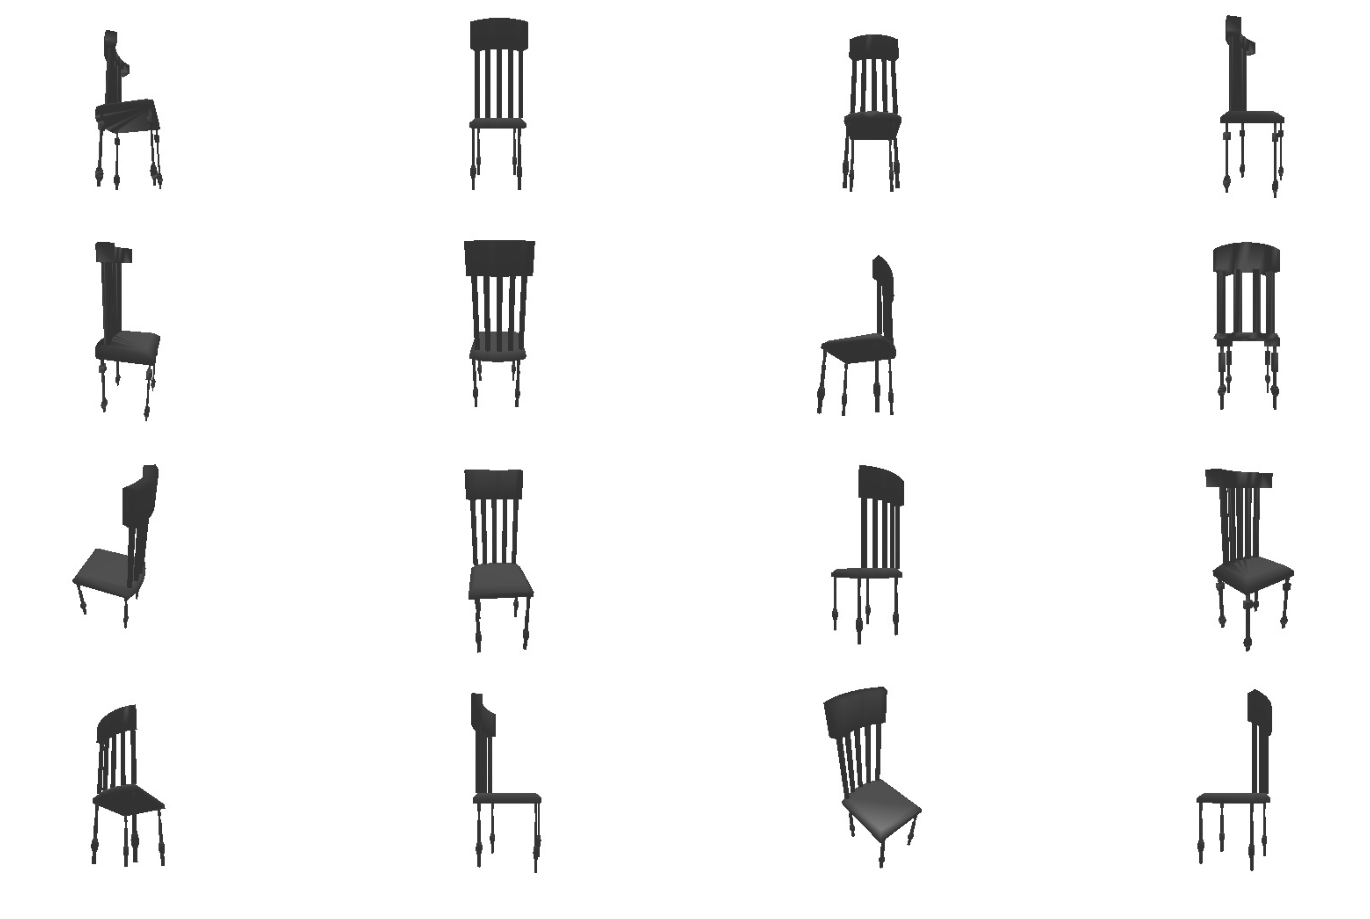

In [41]:
sketch_custom = load_raw_sketch(custom_sketch_path["sketch03"])
sketch_custom_emb = embedd_custom_sketch(sketch_custom)

k = 16
true_label = 0 
true_pos = 10

idx = label_idx(true_label, true_pos)
obj_id = labels[idx]
print(f"Rendered Image for obj-id={true_label} and {true_pos} position.")
plot_single_image(image[idx])
print(f"Sketch for obj-id={true_label} and {true_pos} position.")
plot_single_image(sketch_custom)
print(f"Plot {k}-nn retrieval for obj-id={true_label} and {true_pos} position.")
search_idx, knn_images = search(sketch_custom_emb, k=k)
_knn_images = transform_to_plot(knn_images, batch=True)
image_grid(_knn_images, 4, 4)
print(f"True obj-id: {obj_id}")
print(f"Retrieved object-ids: {labels[search_idx]}")

Rendered Image for obj-id=0 and 10 position.


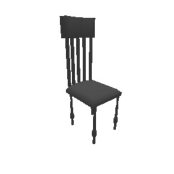

Sketch for obj-id=0 and 10 position.


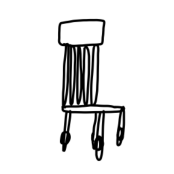

Plot 16-nn retrieval for obj-id=0 and 10 position.
True obj-id: 0
Retrieved object-ids: [24 24  9 23 26 26  9 26 24  9  9 74 26 26 26 23]


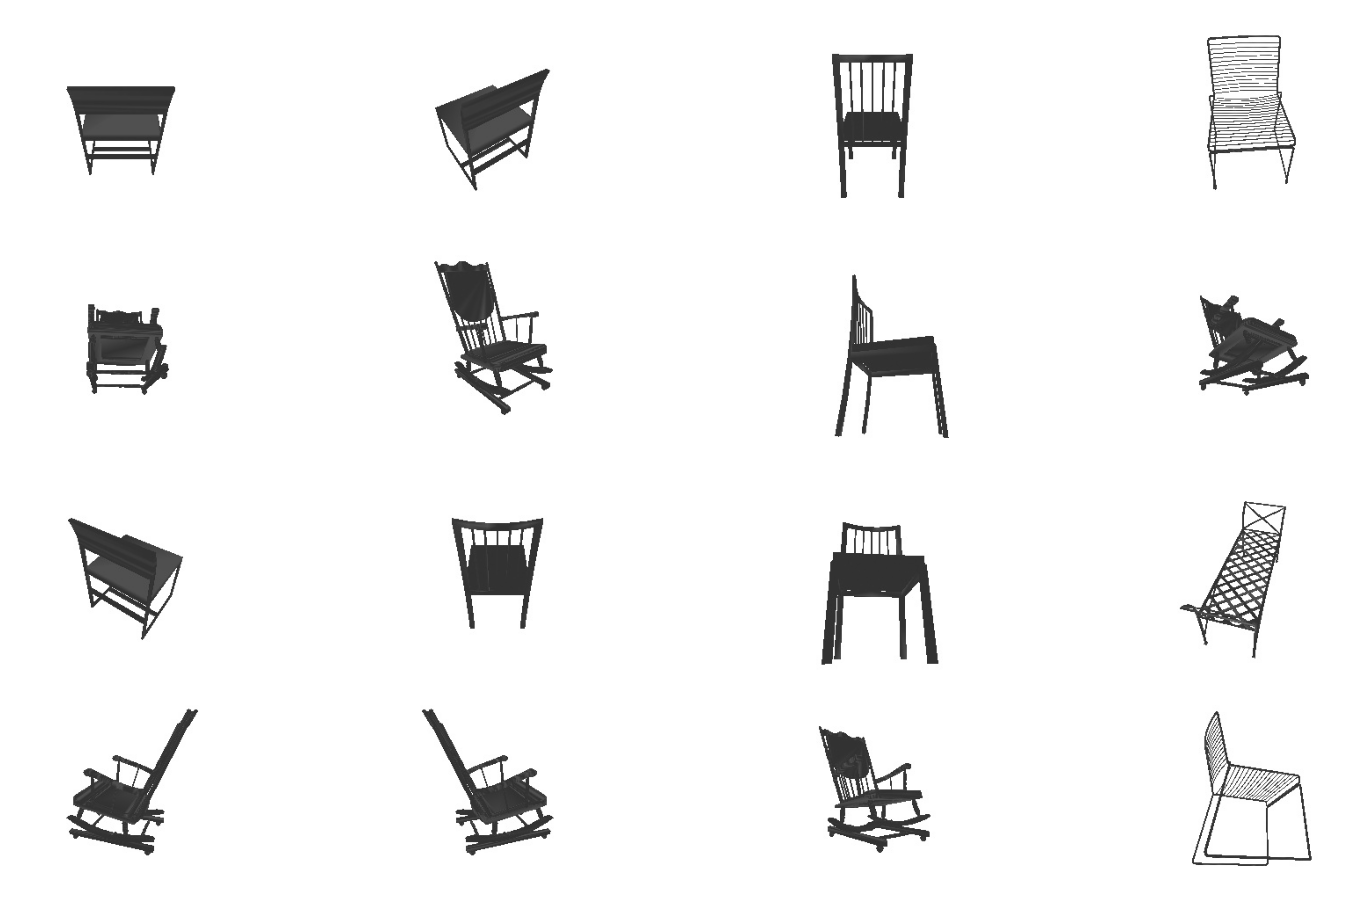

In [10]:
sketch_custom = load_raw_sketch(custom_sketch_path["sketch04"])
sketch_custom_emb = embedd_custom_sketch(sketch_custom)

k = 16
true_label = 0 
true_pos = 10

idx = label_idx(true_label, true_pos)
obj_id = labels[idx]
print(f"Rendered Image for obj-id={true_label} and {true_pos} position.")
plot_single_image(image[idx])
print(f"Sketch for obj-id={true_label} and {true_pos} position.")
plot_single_image(sketch_custom)
print(f"Plot {k}-nn retrieval for obj-id={true_label} and {true_pos} position.")
search_idx, knn_images = search(sketch_custom_emb, k=k)
_knn_images = transform_to_plot(knn_images, batch=True)
image_grid(_knn_images, 4, 4)
print(f"True obj-id: {obj_id}")
print(f"Retrieved object-ids: {labels[search_idx]}")

Rendered Image for obj-id=0 and 10 position.


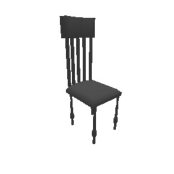

Sketch for obj-id=0 and 10 position.


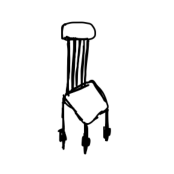

Plot 16-nn retrieval for obj-id=0 and 10 position.
True obj-id: 0
Retrieved object-ids: [ 21  21   0   6  98 106  53   6  21  21 106  21   9   6  53  21]


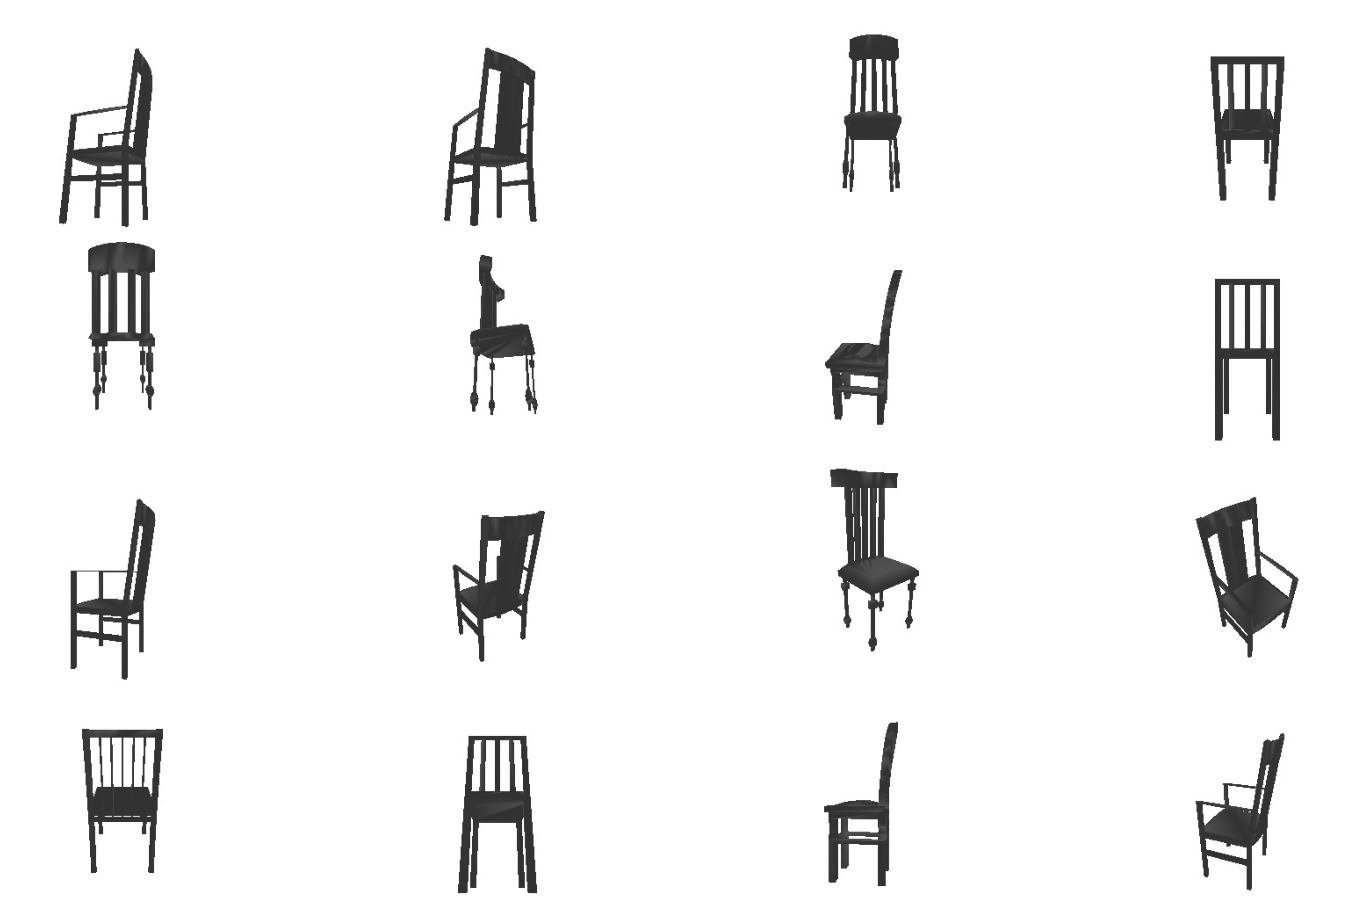

In [45]:
sketch_custom = load_raw_sketch(custom_sketch_path["sketch05"])
sketch_custom_emb = embedd_custom_sketch(sketch_custom)

k = 16
true_label = 0 
true_pos = 10

idx = label_idx(true_label, true_pos)
obj_id = labels[idx]
print(f"Rendered Image for obj-id={true_label} and {true_pos} position.")
plot_single_image(image[idx])
print(f"Sketch for obj-id={true_label} and {true_pos} position.")
plot_single_image(sketch_custom)
print(f"Plot {k}-nn retrieval for obj-id={true_label} and {true_pos} position.")
search_idx, knn_images = search(sketch_custom_emb, k=k)
_knn_images = transform_to_plot(knn_images, batch=True)
image_grid(_knn_images, 4, 4)
print(f"True obj-id: {obj_id}")
print(f"Retrieved object-ids: {labels[search_idx]}")

Rendered Image for obj-id=0 and 10 position.


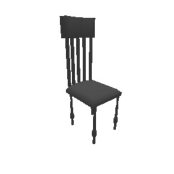

Sketch for obj-id=0 and 10 position.


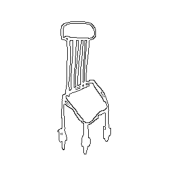

Plot 16-nn retrieval for obj-id=0 and 10 position.
True obj-id: 0
Retrieved object-ids: [ 23  23  23  80 106  23  23  80  23  25  34  80  74  23  23  23]


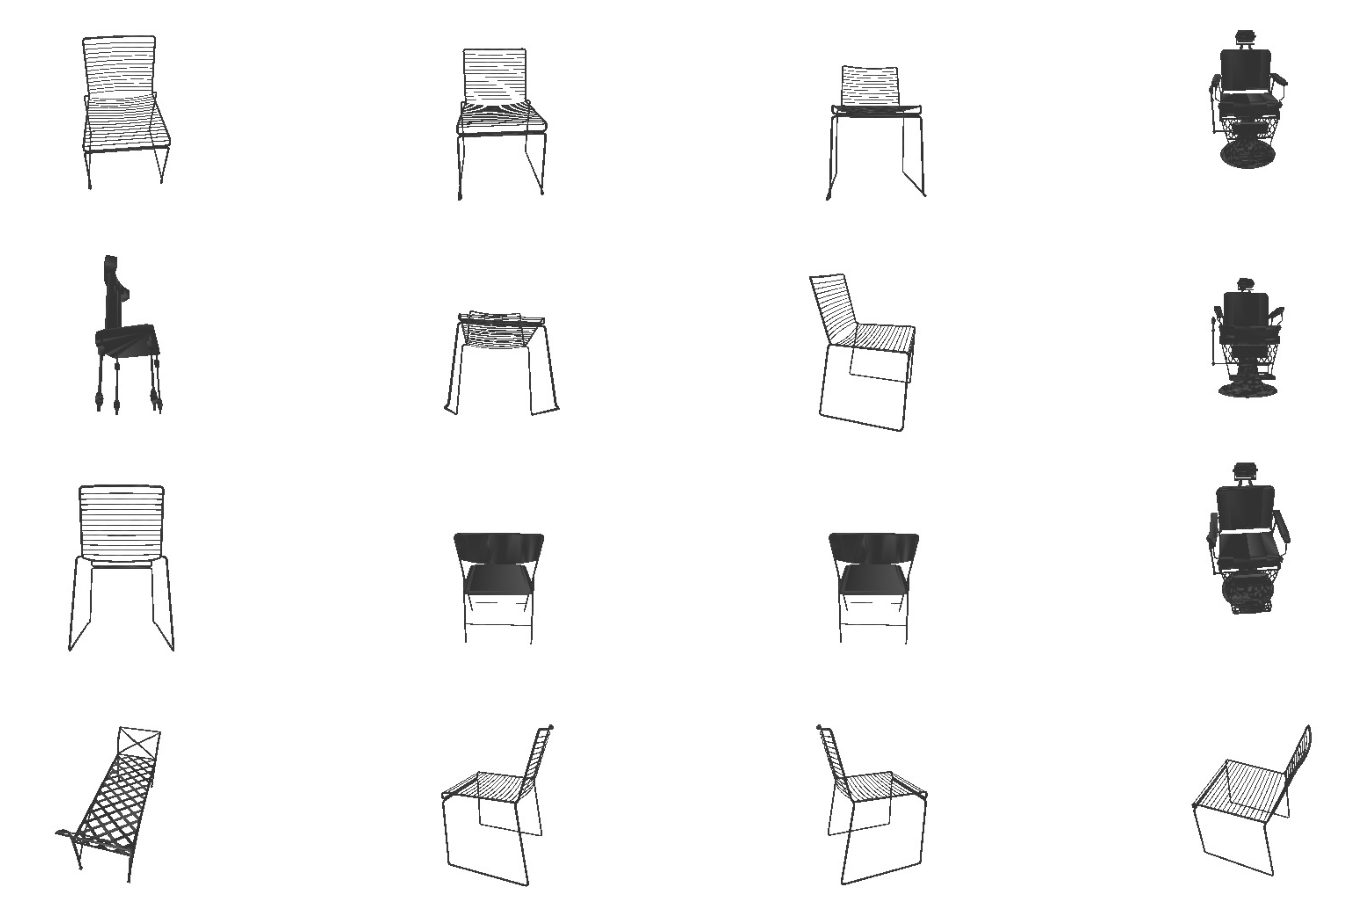

In [46]:
sketch_sketch = sketch_to_sketch(sketch_custom)
sketch_sketch_emb = embedd_custom_sketch(sketch_sketch)

k = 16
true_label = 0 
true_pos = 10

idx = label_idx(true_label, true_pos)
obj_id = labels[idx]
print(f"Rendered Image for obj-id={true_label} and {true_pos} position.")
plot_single_image(image[idx])
print(f"Sketch for obj-id={true_label} and {true_pos} position.")
plot_single_image(sketch_sketch)
print(f"Plot {k}-nn retrieval for obj-id={true_label} and {true_pos} position.")
search_idx, knn_images = search(sketch_sketch_emb, k=k)
_knn_images = transform_to_plot(knn_images, batch=True)
image_grid(_knn_images, 4, 4)
print(f"True obj-id: {obj_id}")
print(f"Retrieved object-ids: {labels[search_idx]}")

Rendered Image for obj-id=0 and 10 position.


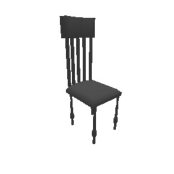

Sketch for obj-id=0 and 10 position.


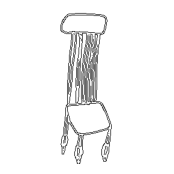

Plot 16-nn retrieval for obj-id=0 and 10 position.
True obj-id: 0
Retrieved object-ids: [106  23 106  80   0  23  23  74   0  39  80 106  39  74  74  26]


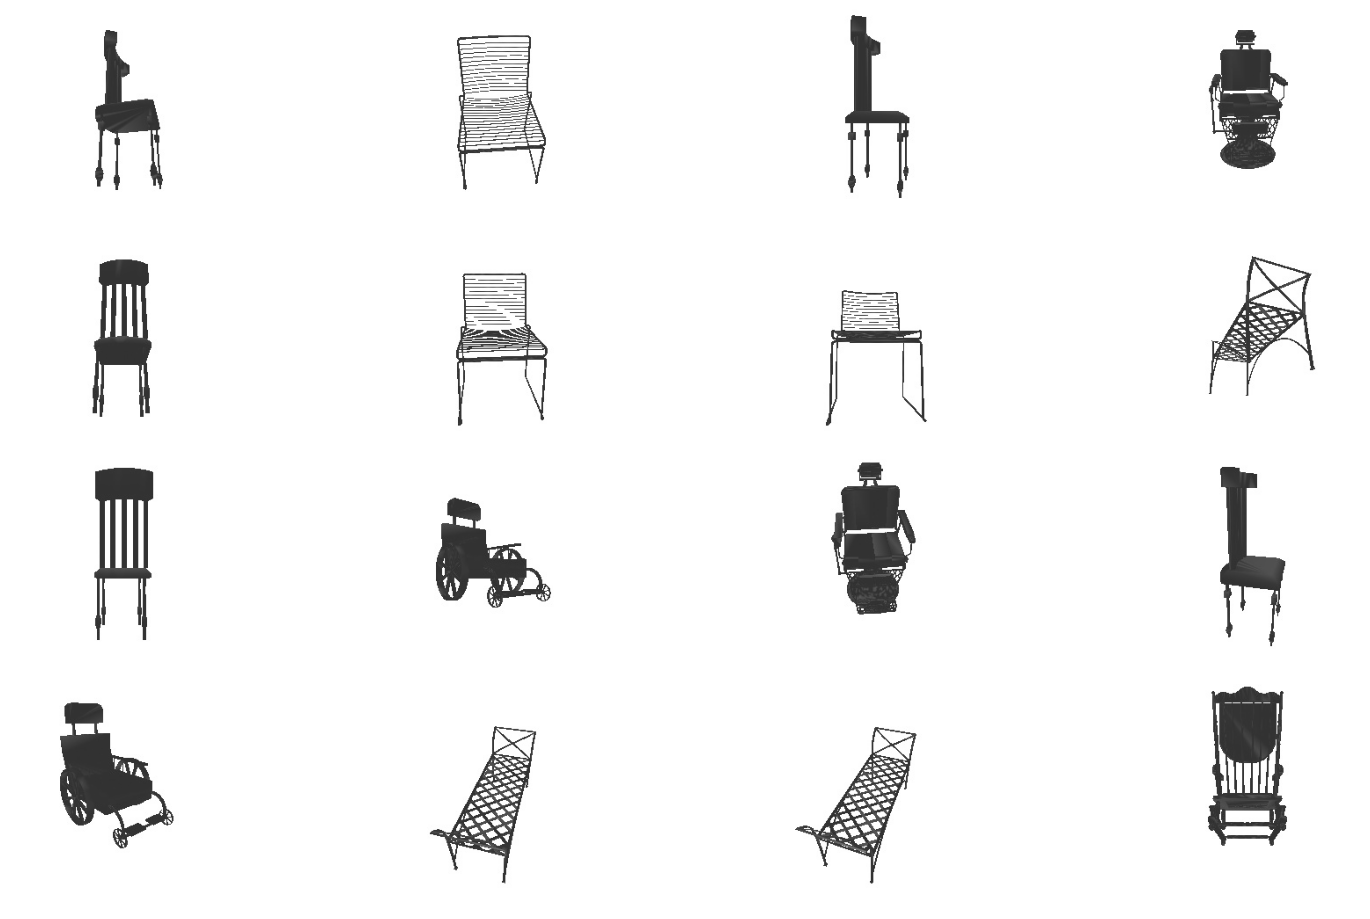

In [42]:
sketch_sketch = sketch_to_sketch(sketch_custom)
sketch_sketch_emb = embedd_custom_sketch(sketch_sketch)

k = 16
true_label = 0 
true_pos = 10

idx = label_idx(true_label, true_pos)
obj_id = labels[idx]
print(f"Rendered Image for obj-id={true_label} and {true_pos} position.")
plot_single_image(image[idx])
print(f"Sketch for obj-id={true_label} and {true_pos} position.")
plot_single_image(sketch_sketch)
print(f"Plot {k}-nn retrieval for obj-id={true_label} and {true_pos} position.")
search_idx, knn_images = search(sketch_sketch_emb, k=k)
_knn_images = transform_to_plot(knn_images, batch=True)
image_grid(_knn_images, 4, 4)
print(f"True obj-id: {obj_id}")
print(f"Retrieved object-ids: {labels[search_idx]}")

Rendered Image for obj-id=0 and 10 position.


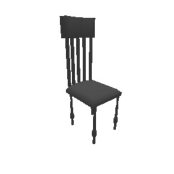

Sketch for obj-id=0 and 10 position.


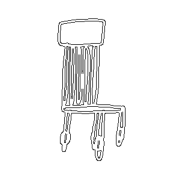

Plot 16-nn retrieval for obj-id=0 and 10 position.
True obj-id: 0
Retrieved object-ids: [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23]


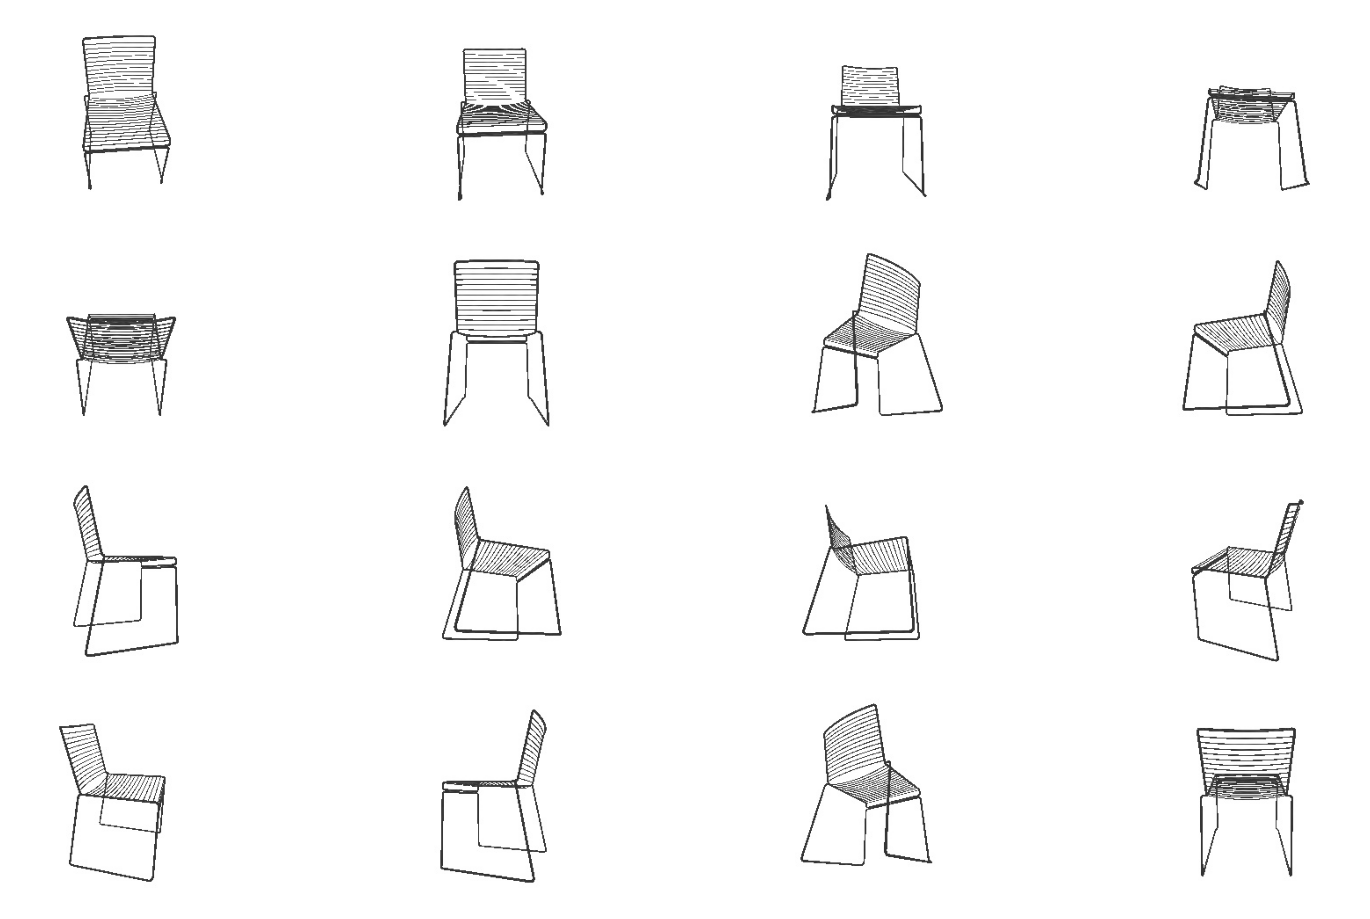

In [39]:
sketch_sketch = sketch_to_sketch(sketch01_raw)
sketch_sketch_emb = embedd_custom_sketch(sketch_sketch)

k = 16
true_label = 0 
true_pos = 10

idx = label_idx(true_label, true_pos)
obj_id = labels[idx]
print(f"Rendered Image for obj-id={true_label} and {true_pos} position.")
plot_single_image(image[idx])
print(f"Sketch for obj-id={true_label} and {true_pos} position.")
plot_single_image(sketch_sketch)
print(f"Plot {k}-nn retrieval for obj-id={true_label} and {true_pos} position.")
search_idx, knn_images = search(sketch_sketch_emb, k=k)
_knn_images = transform_to_plot(knn_images, batch=True)
image_grid(_knn_images, 4, 4)
print(f"True obj-id: {obj_id}")
print(f"Retrieved object-ids: {labels[search_idx]}")

In [59]:
count = 0
dist = 0

for i in range(32):
    for j in range(32):
        dist += get_distance(sketch_emb[i+32], image_emb[j+32])
        count += 1
dist / count

array([[0.4177316]], dtype=float32)

In [61]:
count = 0
dist = 0
for i in range(32):
    for j in range(32):
        dist += get_distance(sketch_emb[i+32], image_emb[j + 128])
        count += 1
dist / count

array([[0.77117336]], dtype=float32)

In [62]:
0.77117336 - 0.4177316

0.35344176000000005